<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/09_mixup_cutmix_erasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q keras-cv --upgrade

import keras_cv
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [6]:
# Step 1: Prepare data
BATCH_SIZE = 64
NUM_CLASSES = 10
AUTOTUNE = tf.data.AUTOTUNE

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train[..., tf.newaxis].astype("float32") / 255.0
x_test = x_test[..., tf.newaxis].astype("float32") / 255.0

# One-hot encode the labels
y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [7]:
# Step 2: Create Dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [9]:
# Step 3: Apply CutMix
cutmix = keras_cv.layers.CutMix(alpha=1.0)

# Apply CutMix augmentation with proper casting
train_ds_cutmix = train_ds.map(
    lambda x, y: cutmix({'images': tf.cast(x, tf.float32), 'labels': tf.cast(y, tf.float32)}),
    num_parallel_calls=AUTOTUNE
)

# Unpack dict output for training
train_ds_cutmix = train_ds_cutmix.map(
    lambda d: (d['images'], d['labels']),
    num_parallel_calls=AUTOTUNE
)

In [10]:
# Step 4: Build Model
cutmix_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

cutmix_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Step 5: Train the Model
cutmix_history = cutmix_model.fit(
    train_ds_cutmix,
    validation_data=(x_test, y_test_cat),
    epochs=10
)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4809 - loss: 1.6411 - val_accuracy: 0.7986 - val_loss: 0.6569
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5705 - loss: 1.4261 - val_accuracy: 0.8110 - val_loss: 0.6195
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5792 - loss: 1.3813 - val_accuracy: 0.8269 - val_loss: 0.5685
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5838 - loss: 1.3667 - val_accuracy: 0.8274 - val_loss: 0.5641
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5904 - loss: 1.3544 - val_accuracy: 0.8355 - val_loss: 0.5467
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5937 - loss: 1.3380 - val_accuracy: 0.8305 - val_loss: 0.5439
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 1.3329 - val_accuracy: 0.8334 - val_loss: 0.5397
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5977 - loss: 1.3271 - val_accuracy: 0

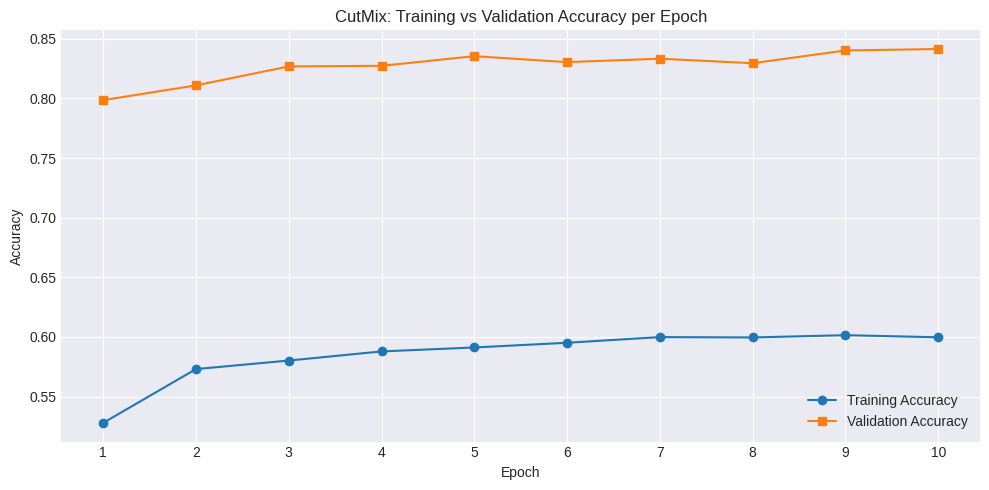

In [19]:
import matplotlib.pyplot as plt

# Extract training & validation accuracy from history
train_acc = cutmix_history.history['accuracy']
val_acc = cutmix_history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'o-', label='Training Accuracy')
plt.plot(epochs, val_acc, 's-', label='Validation Accuracy')
plt.title('CutMix: Training vs Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
